In [1]:
import numpy as np
import matplotlib.pyplot as plt
from BeamPropagator import BeamPropagator
import HelperFuns as hf

## Basic Amplitude Check and Kerr Lensing

In [53]:
xrange = np.arange(-32,32,0.25)
#aperture = np.heaviside(4-np.abs(xrange),0)
aperture = hf.gaussian_amp(3, xrange, waist=1, mu=0)
prop = BeamPropagator(wavelen = 1)
prop.set_x_array(1,1,x_array=xrange)
prop.set_z_array(250, 1000)
prop.set_init_Efield(aperture)
prop.set_abs_bcs(80)
prop.propagate()
fields = prop.field_steps

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
/var/folders/0c/8jgwlmw579z5xqz61k4vsvcm0000gp/T/ipykernel_6501/2881156535.py:5: SyntaxWarning: invalid escape sequence '\s'
  ax[0].set_title("$\sqrt{I}$")
/var/folders/0c/8jgwlmw579z5xqz61k4vsvcm0000gp/T/ipykernel_6501/2881156535.py:7: SyntaxWarning: invalid escape sequence '\m'
  ax[1].set_xlabel("z [$\mu$m]")
/var/folders/0c/8jgwlmw579z5xqz61k4vsvcm0000gp/T/ipykernel_6501/2881156535.py:8: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set_xlabel("z [$\mu$m]")
/var/folders/0c/8jgwlmw57

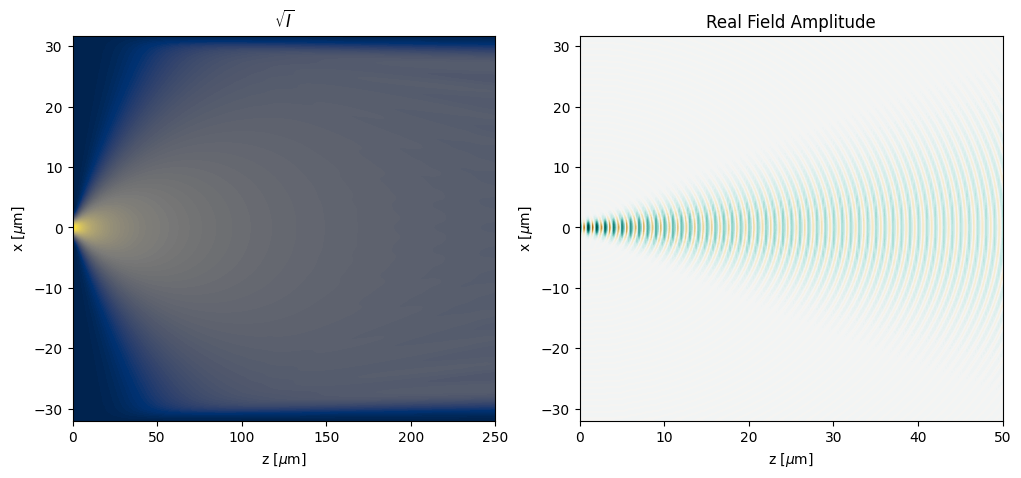

In [54]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
ax[1].contourf(prop.z_arr, xrange, np.transpose(np.real(fields)),100,cmap='BrBG')
ax[1].set_xlim([0,50])
ax[0].contourf(prop.z_arr, xrange, np.transpose(np.abs(fields)**(1/2)),100,cmap='cividis')
ax[0].set_title("$\sqrt{I}$")
ax[1].set_title("Real Field Amplitude")
ax[1].set_xlabel("z [$\mu$m]")
ax[0].set_xlabel("z [$\mu$m]")
ax[0].set_ylabel("x [$\mu$m]")
ax[1].set_ylabel("x [$\mu$m]")
plt.show()

In [55]:
fields = []
z_pos = []
prop = BeamPropagator(wavelen = 1)
prop.set_x_array(x_length=400, num_samples=2048)
E0 = 20 * hf.aperture_mask(prop.x_arr, low_bound=-100, high_bound=100)
prop.set_init_Efield(E0)
prop.set_z_array(50, 200)
prop.set_abs_bcs(80)
prop.propagate()
z_pos.extend(prop.z_arr)
fields.extend(prop.field_steps)
# Add lens and propagate.
E1 = prop.field_steps[-1] * hf.lens_phase_transform(prop.x_arr, focal_len=100, wavelen=1)
prop.set_init_Efield(E1)
prop.set_z_array(200, 800, z_offset=z_pos[-1])
prop.propagate()
fields.extend(prop.field_steps)
z_pos.extend(prop.z_arr)

(-120.0, 120.0)

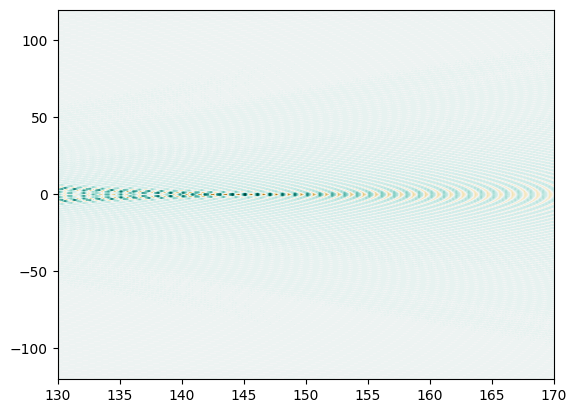

In [56]:
plt.contourf(z_pos, prop.x_arr, np.transpose(np.real(fields)),100,cmap='BrBG')
plt.xlim([130, 170])
plt.ylim(-120,120)

In [62]:
def prop_full(prop:BeamPropagator, n_perturb, end = False):   
    z_pos = []
    fields = []
    # Define propagator.
    prop.set_x_array(x_length=400, num_samples=1024)
    prop.set_z_array(50, 200)
    # Make gaussian initial beam.
    E0 = hf.gaussian_amp(A = 10, x = prop.x_arr, waist = 40, mu = 0)
    prop.set_init_Efield(E0)
    # Absorbing boundary conditions.
    prop.set_abs_bcs(80)
    # Propagate.
    prop.propagate()
    fields.extend(prop.field_steps)
    z_pos.extend(prop.z_arr)
    # Enter medium with n = 2.
    prop.set_base_index(2)
    prop.set_init_Efield(fields[-1])
    prop.set_z_array(200, 800, z_offset=z_pos[-1])
    prop.set_z_dep_idx(n_perturb)
    prop.propagate()
    hol_fields = prop.field_steps # Fields inside kerr medium.
    fields.extend(prop.field_steps)
    z_pos.extend(prop.z_arr)
    # Exit medium with n = 2.
    prop.set_base_index(1)
    prop.rm_z_dep_idx()
    prop.set_init_Efield(fields[-1])
    prop.set_z_array(50, 200, z_offset=z_pos[-1])
    prop.propagate()
    # Store fields
    fields.extend(prop.field_steps)
    z_pos.extend(prop.z_arr)

    if end:
        return fields, z_pos
    return hol_fields, fields

In [63]:
prop = BeamPropagator(wavelen = 1)
n2_init = np.zeros((800, 1024))
for i in range(4):
    hol_fields, _ = prop_full(prop, n2_init)
    n2_init = hf.delta_idx_intensity(np.abs(hol_fields)**2, int_coeff=1.6e-4)
# Final iteration.
fields, z_pos = prop_full(prop, n2_init, end=True)

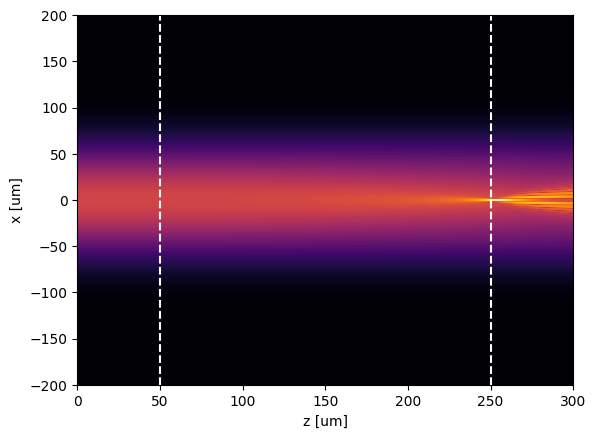

In [64]:
# Plot result.
plt.contourf(z_pos, prop.x_arr, np.transpose(np.abs(fields))**(1/2),100,cmap='inferno')
plt.vlines([50, 250], -200, 200, colors='white',linestyles='dashed')
plt.ylabel("x [um]")
plt.xlabel("z [um]")
plt.show()

(-60.0, 60.0)

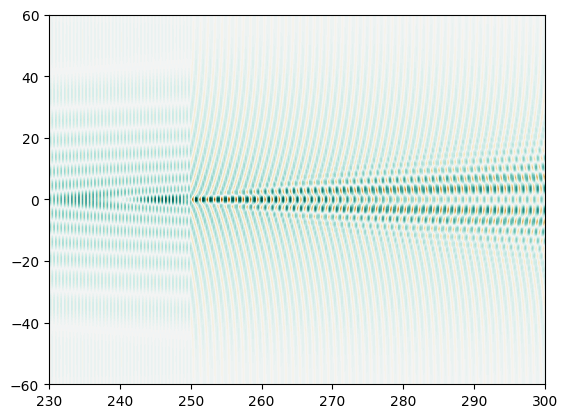

In [71]:
plt.contourf(z_pos, prop.x_arr, np.transpose(np.real(fields)),100,cmap='BrBG')
plt.xlim([230, 300])
plt.ylim([-60, 60])

## Bragg Hologram Evolution

In [2]:
wv = 2
h_len = 160
# x sampling array.
x_arr = np.linspace(-150, 150, 4096)

In [3]:
def propagate_viz_region(E_input, n_perturb=None):
    # Storage containers.
    fields = []
    z_pos = []
    hol_fields = [] 
    # Free space propagation.
    prop = BeamPropagator(wavelen = wv)
    prop.set_x_array(x_length=200, x_array=x_arr)
    prop.set_z_array(z_length = 120, num_samples = 200)
    prop.set_abs_bcs(80)
    prop.set_init_Efield(E_input)
    prop.propagate()
    # Add to storage.
    fields.extend(prop.field_steps)
    z_pos.extend(prop.z_arr)
    # Hologram propagation.
    hol_prop = BeamPropagator(wavelen = wv, index = 1.5)
    hol_prop.set_x_array(x_length = 200, x_array=x_arr)
    hol_prop.set_z_array(z_length = h_len, num_samples = 200, z_offset = z_pos[-1])
    hol_prop.set_abs_bcs(80)
    hol_prop.set_init_Efield(fields[-1])
    if n_perturb is not None:
        hol_prop.set_z_dep_idx(n_perturb)
    hol_prop.propagate()
    # Add to storage.
    fields.extend(hol_prop.field_steps)
    hol_fields.extend(hol_prop.field_steps)
    z_pos.extend(hol_prop.z_arr)
    # Free space propagation.
    prop.set_init_Efield(fields[-1])
    prop.set_z_array(z_length = 100, num_samples = 200, z_offset = z_pos[-1])
    prop.propagate()
    # Add to storage.
    fields.extend(prop.field_steps)
    z_pos.extend(prop.z_arr)
    # Return results.
    return hol_fields, fields, z_pos



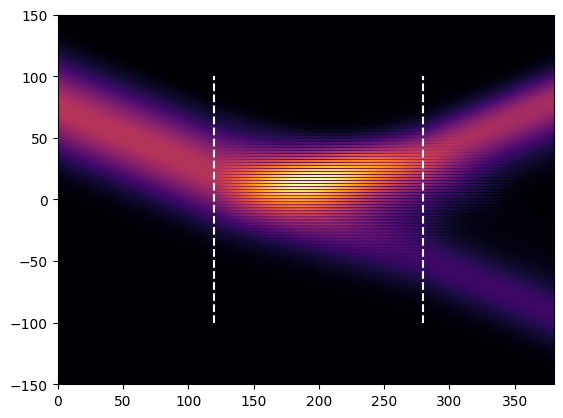

In [35]:
# Set up the inital fields.
img_beam = hf.gaussian_amp(A = 1, x = x_arr, waist = 50, mu = -75) * hf.plane_wave_phase_factor(x_arr, wavelen=wv, theta = 24)
ref_beam = hf.gaussian_amp(A = 1, x = x_arr, waist = 50, mu = 75) * hf.plane_wave_phase_factor(x_arr, wavelen=wv, theta = -24)
# img_beam = hf.aperture_mask(x_arr, low_bound=-120, high_bound=-60) * hf.plane_wave_phase_factor(x_arr, wavelen=wv, theta = 35)
# ref_beam = hf.aperture_mask(x_arr, low_bound=60, high_bound=120) * hf.plane_wave_phase_factor(x_arr, wavelen=wv, theta = -35)
# Propagate the beams separately.
hol_fields_img, fields_img, z_pos = propagate_viz_region(img_beam)
hol_fields_ref, fields_ref, z_pos = propagate_viz_region(ref_beam)
# Update the hologram region.
delta_idx = None
int_coeff = 0.1 * 4.5677e-3
for i in range(40):
    hol_fields = np.array(hol_fields_img) + np.array(hol_fields_ref)
    intensity = np.abs(hol_fields)**2 - np.abs(np.array(hol_fields_img))**2 - np.abs(np.array(hol_fields_ref))**2
    if delta_idx is not None:
        delta_idx = 0.9 * delta_idx + hf.delta_idx_intensity(intensity, int_coeff)
    else:
        delta_idx = hf.delta_idx_intensity(intensity, int_coeff)
    # delta_idx[delta_idx > 0.5] = 0.5
    # delta_idx[delta_idx < -0.5] = -0.5
    # Propagate the beams separately.
    hol_fields_img, fields_img, z_pos = propagate_viz_region(img_beam, n_perturb=delta_idx)
    hol_fields_ref, fields_ref, z_pos = propagate_viz_region(ref_beam, n_perturb=delta_idx)
# Combine the fields and plot.
fields = np.array(fields_ref) #+ np.array(fields_img)
plt.contourf(z_pos, x_arr, np.transpose(np.abs(fields))**(2),100,cmap='inferno')
plt.vlines([120, 120 + h_len], -100, 100, colors='white',linestyles='dashed')
plt.show()